# Analyze substrate solvation

This notebook demonstrates deposition of an SDS adsorption layer on a non-spherical AFM tip model.

## Initialization

### IPython magic

In [315]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



### Imports

In [316]:
import ase.io # here used for reading pdb files
from ase.visualize import view
from ase.visualize.plot import plot_atoms # has nasty offset issues
from cycler import cycler # here used for cycling through colors in plots
import datetime
import fabric # for pythonic ssh connections
from fireworks import LaunchPad, Firework, Tracker, Workflow 
from fireworks import FileTransferTask, PyTask, ScriptTask

# FireWorks functionality 
from fireworks import Firework, LaunchPad, ScriptTask, Workflow
from fireworks.user_objects.firetasks.templatewriter_task import TemplateWriterTask
from fireworks.user_objects.firetasks.filepad_tasks import AddFilesTask, GetFilesTask, GetFilesByQueryTask
from imteksimfw.fireworks.user_objects.firetasks.cmd_tasks import CmdTask
from fireworks.utilities.filepad import FilePad # direct FilePad access, similar to the familiar LaunchPad

from collections.abc import Iterable
import glob
import gc # manually clean up memory with gc.collect()
import gromacs # GromacsWrapper, here used for evoking gmc commands, reading and writing .ndx files
# from io import StringIO, TextIOWrapper
import io
from IPython.display import display, Image #, Video # display image files within notebook
from ipywidgets import Video  # display video within notebook
import itertools # for products of iterables
import json # generic serialization of lists and dicts
import jinja2 # here used for filling packmol input script template
import jinja2.meta # for gathering variables in a jinja2 template
import logging 
import matplotlib.pyplot as plt
import MDAnalysis as mda # here used for reading and analyzing gromacs trajectories
import MDAnalysis.analysis.rdf as mda_rdf
import MDAnalysis.analysis.rms as mda_rms
from mpl_toolkits.mplot3d import Axes3D # here used for 3d point cloud scatter plot
import miniball # finds minimum bounding sphere of a point set
import nglview
import numpy as np
import os, os.path
import pandas as pd
import panedr # reads GROMACS edr into pandas df, requires pandas and pbr
import parmed as pmd # has quite a few advantages over ASE when it comes to parsing pdb
from pprint import pprint
import pymongo # for sorting in queries
import scipy.constants as sc
import subprocess # used for evoking external packmol
import sys
import tempfile
import yaml

GromacsWrapper might need a file `~/.gromacswrapper.cfg` with content
```cfg
[Gromacs]
tools = gmx gmx_d 
# gmx_mpi_d gmx_mpi_d

# name of the logfile that is written to the current directory
logfilename = gromacs.log

# loglevels (see Python's logging module for details)
#   ERROR   only fatal errors
#   WARN    only warnings
#   INFO    interesting messages
#   DEBUG   everything

# console messages written to screen
loglevel_console = INFO

# file messages written to logfilename
loglevel_file = DEBUG
```
in order to know the GROMACS executables it is allowed to use. Otherwise,
calls to `gmx_mpi` or `gmx_mpi_d` without MPI wrapper might lead to MPI 
warnings in output that cause GromacsWrapper to fail.

### Logging

In [317]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

ParmEd needs to know the GROMACS topology folder, usually get this from 
envionment variable `GMXLIB`:

### Function definitions

In [318]:
def find_undeclared_variables(infile):
    """identify all variables evaluated in a jinja 2 template file"""
    env = jinja2.Environment()
    with open(infile) as template_file:
        parsed = env.parse(template_file.read())

    undefined = jinja2.meta.find_undeclared_variables(parsed)
    return undefined

In [319]:
def memuse():
    """Quick overview on memory usage of objects in Jupyter notebook"""
    # https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    return sorted([(x, sys.getsizeof(globals().get(x))) for x in dir(sys.modules['__main__']) if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

### Global settings

In [19]:
# pandas settings
pd.options.display.max_rows = 200
pd.options.display.max_columns = 16
pd.options.display.max_colwidth = 256

In [320]:
os.environ['GMXLIB'] = '/gmx_top'

In [321]:
# pmd.gromacs.GROMACS_TOPDIR = os.environ['GMXLIB']
pmd.gromacs.GROMACS_TOPDIR = '/gmx_top'

In [322]:
# prefix = '/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol'
prefix = '/mnt/dat/work'

In [323]:
work_prefix = '/mnt/dat/work/tmp'

In [324]:
try:
    os.mkdir(work_prefix)
except FileExistsError as exc:
    print(exc)

[Errno 17] File exists: '/mnt/dat/work/tmp'


In [325]:
os.chdir(work_prefix)

In [326]:
# the FireWorks LaunchPad
lp = LaunchPad.auto_load() #Define the server and database
# FilePad behaves analogous to LaunchPad
fp = FilePad.auto_load()

## Conversion from LAMMPS data format to PDB

The following bash / tcl snippet converts a LAMMPS data file to PDB, assigning the desired names as mapped in a yaml file
```bash
#!/bin/bash
# echo "package require jlhvmd; jlh lmp2pdb indenter.lammps indenter.pdb" | vmd -eofexit
vmd -eofexit << 'EOF'
package require jlhvmd
topo readlammpsdata indenter.lammps
jlh type2name SDS_type2name.yaml
jlh name2res  SDS_name2res.yaml
set sel [atomselect top all]
$sel writepdb indenter.pdb
EOF

pdb_chain.py indenter.pdb > indenter_wo_chainid.pdb
pdb_reres_by_atom_9999.py indenter_wo_chainid.pdb > indenter_reres.pdb
```

Requires

* VMD (tested with 1.9.3) with topotools
* jlhvmd VMD plugin: https://github.com/jotelha/jlhvmd
* pdb-tools: https://github.com/haddocking/pdb-tools/

## Overview

### Overview on projects in database

In [27]:
query = {'metadata.datetime': {'$gt': '2020'} }

In [28]:
fp.filepad.count_documents(query)

2537

In [29]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 'project': '$metadata.project' },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # pull 'project' field up in hierarchy
        "$addFields": { 
            "project": "$_id.project",
        },
    },
    {  # drop nested '_id.project'
        "$project": { 
            "_id": False 
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

# sort_aggregation
#aggregation_pipeline = [ match_aggregation, group_aggregation, set_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [c for c in cursor]
res_df = pd.DataFrame(data=res) # pandas Dataframe is just nice for printing in notebook

In [30]:
res_df

,object_count,earliest,latest,project
0,410,2020-09-09 23:24:22.512782,2020-09-09 23:24:23.635704,2020-09-10-sds-on-au-111-substrate-passivation-trial
1,210,2020-09-08 23:15:38.029121,2020-09-09 17:35:18.670720,2020-09-09-sds-on-au-111-substrate-passivation-trial
2,252,2020-09-08 18:12:59.181303,2020-09-08 18:12:59.406524,2020-09-08-sds-on-au-111-substrate-passivation-trial
3,343,2020-09-03 15:46:52.139300,2020-09-03 23:22:15.222281,2020-09-03-sds-on-au-111-substrate-passivation-trial
4,245,2020-09-01 16:07:48.182428,2020-09-02 15:39:12.955771,2020-09-01-sds-on-au-111-substrate-passivation-trial
5,52,2020-08-31 02:32:35.171803,2020-09-01 00:35:40.345368,2020-08-31-sds-on-au-111-substrate-passivation-trial
6,3,2020-08-31 01:32:13.820858,2020-08-31 01:32:13.902597,2020-08-30-sds-on-au-111-substrate-passivation-trial
7,6,2020-08-28 00:14:08.820442,2020-08-28 00:35:31.724026,2020-08-27-sds-on-au-111-substrate-passivation-trial
8,80,2020-08-24 17:48:58.997210,2020-08-24 20:24:33.489028,2020-08-24-au-111-fcc-substrate-creation-trial
9,537,2020-07-29 03:50:20.375090,2020-07-29 03:50:22.884335,2020-07-29-ctab-on-au-111-indenter-passivation


### Overview on steps in project

In [31]:
project_id = '2020-09-10-sds-on-au-111-substrate-passivation-trial'

In [32]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [33]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

420

In [34]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [35]:
res_df

,step,earliest,latest,object_count
0,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad,2020-09-09 23:24:23.635587,2020-09-09 23:24:23.635704,23
1,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:push_filepad,2020-09-09 23:24:23.582382,2020-09-09 23:24:23.582484,20
2,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNVTEquilibration:push_filepad,2020-09-09 23:24:23.536374,2020-09-09 23:24:23.536474,31
3,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsEnergyMinimizationAfterSolvation:push_filepad,2020-09-09 23:24:23.493508,2020-09-09 23:24:23.493605,19
4,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsSolvate:push_filepad,2020-09-09 23:24:23.451237,2020-09-09 23:24:23.451246,2
5,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsPrep:push_filepad,2020-09-09 23:24:23.440088,2020-09-09 23:24:23.440094,2
6,SubstratePassivation:HemicylindricalPackingAndEquilibartion:PDBCleanup:push_filepad,2020-09-09 23:24:23.439450,2020-09-09 23:24:23.439450,1
7,SubstratePassivation:HemicylindricalPackingAndEquilibartion:HemicylindricalPacking:HemicylindricalPackingMain:push_filepad,2020-09-09 23:24:23.438865,2020-09-09 23:24:23.438865,1
8,SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad,2020-09-09 23:24:23.437852,2020-09-09 23:24:23.437963,23
9,SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:push_filepad,2020-09-09 23:24:23.386750,2020-09-09 23:24:23.386845,20


In [36]:
res_df['step'].values

array(['SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad',
       'SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:push_filepad',
       'SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNVTEquilibration:push_filepad',
       'SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsEnergyMinimizationAfterSolvation:push_filepad',
       'SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsSolvate:push_filepad',
       'SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsPrep:push_filepad',
       'SubstratePassivation:HemicylindricalPackingAndEquilibartion:PDBCleanup:push_filepad',
       'Substrate

### Overview on objects in project

In [37]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [38]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

420

In [39]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'step', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [40]:
res_df

,type,step,name,earliest,latest,object_count
0,mp4_file,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad,NaN,2020-09-09 23:24:23.635704,2020-09-09 23:24:23.635704,1
1,surfactant_tail_rmsd,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad,NaN,2020-09-09 23:24:23.635698,2020-09-09 23:24:23.635698,1
2,surfactant_head_rmsd,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad,NaN,2020-09-09 23:24:23.635693,2020-09-09 23:24:23.635693,1
3,substrate_rmsd,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad,NaN,2020-09-09 23:24:23.635688,2020-09-09 23:24:23.635688,1
4,counterion_rmsd,SubstratePassivation:HemicylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad,NaN,2020-09-09 23:24:23.635683,2020-09-09 23:24:23.635683,1
...,...,...,...,...,...,...
352,input,SubstratePassivation:MonolayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:GromacsNPTEquilibrationMain:push_infiles,npt_z_only.mdp,None,None,1
353,input,SubstratePassivation:MonolayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsEnergyMinimizationAfterSolvation:GromacsTrajectoryVisualization:push_infiles,movie.pml.template,None,None,1
354,input,SubstratePassivation:MonolayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsPrep:GromacsPrepMain:push_infiles,sys.top.template,None,None,1
355,counterion_file,SubstratePassivation:MonolayerPackingAndEquilibartion:MonolayerPacking:LayeredPackingMain:push_infiles,1_NA.pdb,None,None,1


### Overview on images by distinct steps

In [41]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
}

In [42]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [43]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [44]:
res_df

,step,type,name,earliest,latest,object_count
0,SubstratePassivation:ComponentMeasures:SurfactantMoleculeMeasures:push_filepad,png_file,NaN,2020-09-09 23:24:22.849320,2020-09-09 23:24:22.849320,1


In [45]:
res_df["step"][0]

'SubstratePassivation:ComponentMeasures:SurfactantMoleculeMeasures:push_filepad'

## Packing visualization

### Surfactant measures

In [46]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'SurfactantMoleculeMeasures'}
}

In [47]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [48]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

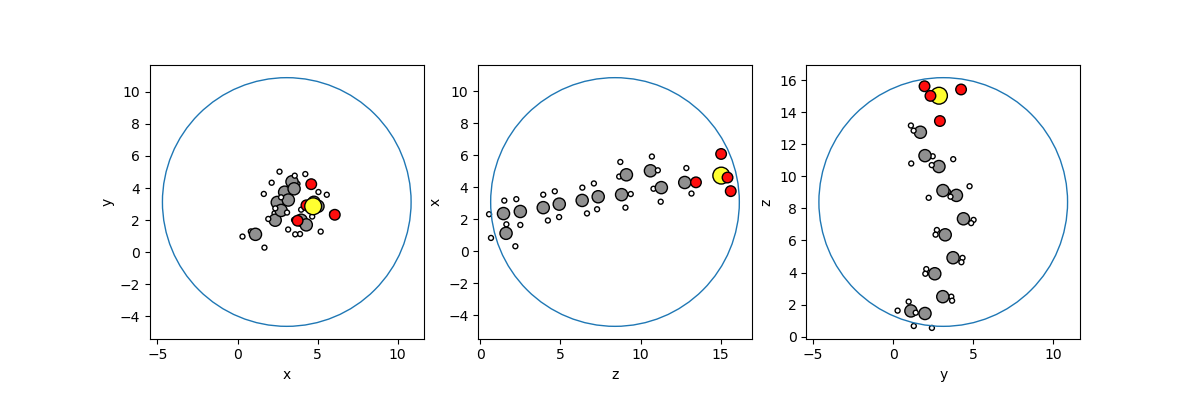

In [49]:
obj_list[0]

## Energy minimization after solvation analysis

### Overview on objects in step

In [64]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsEnergyMinimizationAfterSolvation'}
}

In [65]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

92

In [66]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [67]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-09-09 23:24:22.897645,2020-09-09 23:24:23.493605,4
1,surfactant_tail_rmsd,NaN,2020-09-09 23:24:22.897640,2020-09-09 23:24:23.493600,4
2,surfactant_head_rmsd,NaN,2020-09-09 23:24:22.897635,2020-09-09 23:24:23.493595,4
3,substrate_rmsd,NaN,2020-09-09 23:24:22.897631,2020-09-09 23:24:23.493590,4
4,counterion_rmsd,NaN,2020-09-09 23:24:22.897626,2020-09-09 23:24:23.493585,4
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.897621,2020-09-09 23:24:23.493579,4
6,surfactant_head_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.897616,2020-09-09 23:24:23.493574,5
7,surfactant_head_surfactant_head_rdf,NaN,2020-09-09 23:24:22.897612,2020-09-09 23:24:23.493569,5
8,substrate_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.897607,2020-09-09 23:24:23.493564,5
9,substrate_surfactant_head_rdf,NaN,2020-09-09 23:24:22.897602,2020-09-09 23:24:23.493559,5


### Global observables

In [73]:
query = { 
    "metadata.project": project_id,
    'metadata.step': {'$regex': 'GromacsEnergyMinimizationAfterSolvation'},
    "metadata.type": 'energy_file',
}
fp.filepad.count_documents(query)

5

In [75]:
#parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}

In [76]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [77]:
res_mi_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        em_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),em_df.index],
            names=[*c["_id"].keys(),'step'])
        em_mi_df = em_df.set_index(mi)        
        res_mi_list.append(em_mi_df)
    print('.',end='')
print('')

res_mi_df = pd.concat(res_mi_list)
res_df = res_mi_df.reset_index()

....


In [78]:
res_mi_df

Time          Bond            U-B   Proper Dih.  \
shape     step                                                        
cylinders 0.0        0.0  36044.589844  132023.750000  17566.015625   
          1.0        1.0  36080.382812  132058.531250  17566.849609   
          2.0        2.0  36080.480469  132058.515625  17566.851562   
          3.0        3.0  36080.566406  132058.468750  17566.853516   
          4.0        4.0  36080.671875  132058.421875  17566.853516   
...                  ...           ...            ...           ...   
bilayer   8372.0  8372.0    520.313110   34550.671875  12189.627930   
          8373.0  8373.0    521.227905   34551.105469  12189.621094   
          8375.0  8375.0    515.212097   34549.738281  12189.617188   
          8376.0  8376.0    524.375732   34551.906250  12189.593750   
          8377.0  8377.0    516.204895   34549.937500  12189.593750   

                        LJ-14     Coulomb-14       LJ (SR)  Coulomb (SR)  ...  \
shape     step                                                            ...   
cylinders 0.0     7881.753906  116726.078125  3.819503e+09    -5911059.5  ...   
          1.0     7880.544922  116724.687500  3.603216e+09    -5911060.5  ...   
          2.0     7880.559570  116724.687500  3.357597e+09    -5911060.5  ...   
          3.0     7880.579102  116724.687500  3.086333e+09    -5911060.5  ...   
          4.0     7880.604004  116724.687500  2.790985e+09    -5911061.0  ...   
...                       ...            ...           ...           ...  ...   
bilayer   8372.0  2825.320068  116667.648438 -3.357745e+07    -7276251.0  ...   
          8373.0  2825.159668  116667.835938 -3.357744e+07    -7276259.5  ...   
          8375.0  2825.252441  116667.742188 -3.357744e+07    -7276264.5  ...   
          8376.0  2825.174316  116667.820312 -3.357743e+07    -7276312.0  ...   
          8377.0  2825.253174  116667.617188 -3.357743e+07    -7276318.5  ...   

                   Pres-YX     Pres-YY   Pres-YZ    Pres-ZX   Pres-ZY  \
shape     step                                                          
cylinders 0.0    -2.644662 -169.734436 -3.714011  12.786861 -3.714012   
          1.0    -2.644707 -169.734467 -3.714024  12.786866 -3.714023   
          2.0    -2.644716 -169.734467 -3.714022  12.786838 -3.714020   
          3.0    -2.644718 -169.734406 -3.714022  12.786829 -3.714023   
          4.0    -2.644726 -169.734467 -3.714028  12.786852 -3.714026   
...                    ...         ...       ...        ...       ...   
bilayer   8372.0 -3.100199 -205.556854 -3.994766   7.676005 -3.994765   
          8373.0 -3.100017 -205.557465 -3.994670   7.675970 -3.994670   
          8375.0 -3.099863 -205.557831 -3.994618   7.675908 -3.994619   
          8376.0 -3.099004 -205.559967 -3.994122   7.675763 -3.994122   
          8377.0 -3.098839 -205.560272 -3.994093   7.675716 -3.994091   

                     Pres-ZZ  #Surf*SurfTen  T-rest  
shape     step                                       
cylinders 0.0    -173.118988           -0.0     0.0  
          1.0    -173.118942           -0.0     0.0  
          2.0    -173.118988           -0.0     0.0  
          3.0    -173.119019           -0.0     0.0  
          4.0    -173.119003           -0.0     0.0  
...                      ...            ...     ...  
bilayer   8372.0 -201.217560            0.0     0.0  
          8373.0 -201.217651            0.0     0.0  
          8375.0 -201.217407            0.0     0.0  
          8376.0 -201.218094            0.0     0.0  
          8377.0 -201.218170            0.0     0.0  

[28966 rows x 33 columns]

In [89]:
parameter_keys = list(parameter_dict.keys())

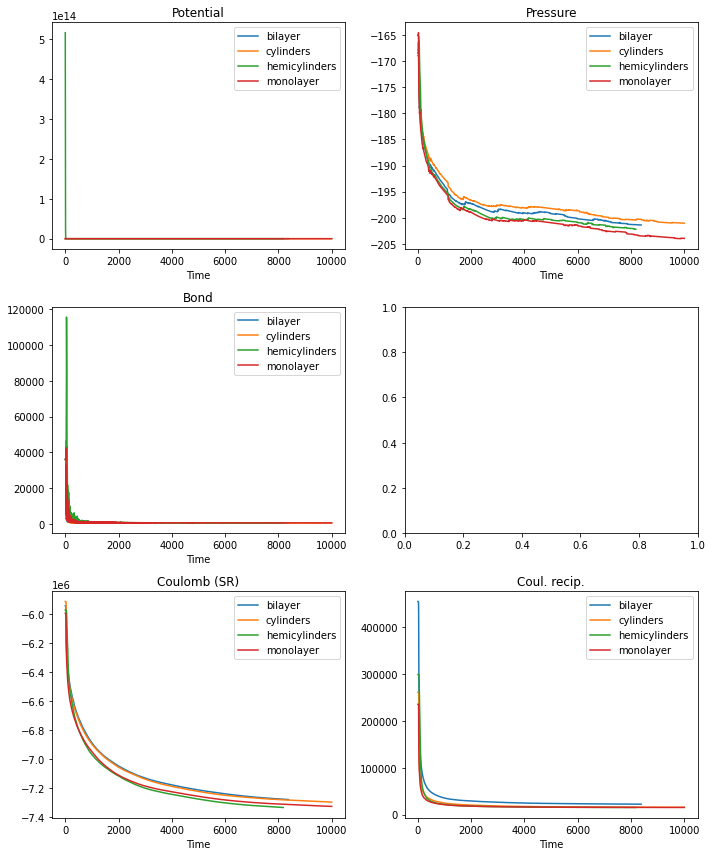

In [90]:
y_quantities = [
    'Potential',
    'Pressure',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

positions = [
    (0,0),
    (0,1),
    (1,0),
    (2,0),
    (2,1),
]
fig, ax = plt.subplots(3,2,figsize=(10,12))
for key, grp in res_df.groupby(parameter_keys[0]):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Visualize trajectory

In [91]:
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsEnergyMinimizationAfterSolvation'},
    'metadata.type': 'mp4_file',
}

In [92]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

4

In [93]:
# check

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'nmolecules': '$metadata.system.surfactant.nmolecules'
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

# for i, c in enumerate(cursor): 
#    content, metadata = fp.get_file_by_id(c["latest"])
#    nmolecules = int(c["_id"]["nmolecules"])
    

res = [ {**c['_id'], **c} for c in cursor]
columns = ['nmolecules', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [94]:
res_df

,nmolecules,name,earliest,latest,object_count
0,450,NaN,2020-09-09 23:24:22.897645,2020-09-09 23:24:23.493605,4


In [103]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        obj_dict.update({c["_id"][parameter_keys[0]]: Video.from_file(tmp.name)})
    print('.',end='')

....

In [104]:
c

{'_id': {'shape': 'bilayer'},
 'degeneracy': 1,
 'latest': '5f59854b71af2580b88a03bf'}

In [105]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

monolayer


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01\xcc\xc7mdat\x0…

hemicylinders


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01{\x9emdat\x00\x…

cylinders


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x026mmdat\x00\x00\…

bilayer


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02tdmdat\x00\x00\…

## NVT equilibration analysis

### Overview on objects in step

In [117]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsNVTEquilibration'}
}

In [118]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

128

In [119]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [120]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-09-09 23:24:22.939233,2020-09-09 23:24:23.536474,4
1,surfactant_tail_rmsd,NaN,2020-09-09 23:24:22.939229,2020-09-09 23:24:23.536469,4
2,surfactant_head_rmsd,NaN,2020-09-09 23:24:22.939224,2020-09-09 23:24:23.536464,4
3,substrate_rmsd,NaN,2020-09-09 23:24:22.939219,2020-09-09 23:24:23.536459,4
4,counterion_rmsd,NaN,2020-09-09 23:24:22.939214,2020-09-09 23:24:23.536454,4
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.939209,2020-09-09 23:24:23.536449,4
6,surfactant_head_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.939205,2020-09-09 23:24:23.536444,4
7,surfactant_head_surfactant_head_rdf,NaN,2020-09-09 23:24:22.939200,2020-09-09 23:24:23.536439,6
8,substrate_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.939195,2020-09-09 23:24:23.536434,6
9,substrate_surfactant_head_rdf,NaN,2020-09-09 23:24:22.939191,2020-09-09 23:24:23.536429,7


### Global observables

In [121]:
query = { 
    "metadata.project": project_id,
    'metadata.step': {'$regex': 'GromacsNVTEquilibration'},
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

8

In [159]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [123]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [124]:
[ c for c in cursor]

[{'_id': {'shape': 'bilayer'},
  'degeneracy': 1,
  'latest': '5f5990bc71af2580b88a0f5a'},
 {'_id': {'shape': 'cylinders'},
  'degeneracy': 1,
  'latest': '5f599114e4b09a738989f24c'},
 {'_id': {'shape': 'hemicylinders'},
  'degeneracy': 2,
  'latest': '5f59942b71af2580b88a28bd'},
 {'_id': {'shape': 'monolayer'},
  'degeneracy': 4,
  'latest': '5f599125cd1d380ee689f6b6'}]

In [125]:
res_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

....


In [126]:
res_df.columns

Index(['shape', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfactant-rest', 'LJ-SR:Surfactant-rest',
       'Coul-14:Surfactant-rest', 'LJ-14:Surfacta

In [127]:
res_df_mi

Time         Bond           U-B   Proper Dih.        LJ-14  \
shape     step                                                                 
monolayer 0.0      0.0   757.672852  36754.984375  13666.833008  2831.123047   
          1.0      1.0  6072.635254  62135.027344  16821.007812  3968.857178   
          2.0      2.0  7043.149414  66865.164062  17400.121094  4203.334961   
          3.0      3.0  7584.031250  70226.453125  17500.994141  4399.842773   
          4.0      4.0  8180.255859  72050.539062  17701.945312  4308.985352   
...                ...          ...           ...           ...          ...   
bilayer   96.0    96.0  8251.164062  71247.179688  16848.527344  4539.994141   
          97.0    97.0  8229.352539  71898.085938  16646.826172  4358.174316   
          98.0    98.0  8124.267578  71451.851562  16786.306641  4400.736816   
          99.0    99.0  7982.408203  71490.265625  16695.302734  4451.194336   
          100.0  100.0  8240.716797  71354.726562  16910.851562  4424.435059   

                    Coulomb-14     LJ (SR)  Coulomb (SR)  ...  \
shape     step                                            ...   
monolayer 0.0    115976.046875 -33572684.0    -7323069.0  ...   
          1.0    115534.460938 -33668304.0    -6581323.5  ...   
          2.0    115347.781250 -33699096.0    -6424427.0  ...   
          3.0    115294.640625 -33733212.0    -6291717.0  ...   
          4.0    115091.695312 -33755496.0    -6201416.0  ...   
...                        ...         ...           ...  ...   
bilayer   96.0   115980.523438 -33839604.0    -5898105.5  ...   
          97.0   115574.062500 -33838320.0    -5900272.5  ...   
          98.0   115631.156250 -33839268.0    -5901286.0  ...   
          99.0   115687.148438 -33839028.0    -5899523.0  ...   
          100.0  115513.859375 -33839240.0    -5900519.0  ...   

                 Coul-SR:rest-rest  LJ-SR:rest-rest  Coul-14:rest-rest  \
shape     step                                                           
monolayer 0.0           -6883874.5      776741.7500                0.0   
          1.0           -6136436.5      694316.4375                0.0   
          2.0           -5974390.0      669757.9375                0.0   
          3.0           -5834596.0      639666.0000                0.0   
          4.0           -5747174.5      620477.3750                0.0   
...                            ...              ...                ...   
bilayer   96.0          -5402160.5      550032.8750                0.0   
          97.0          -5404704.5      551417.5625                0.0   
          98.0          -5404624.5      549728.6875                0.0   
          99.0          -5404809.0      551109.8750                0.0   
          100.0         -5406736.5      551221.1250                0.0   

                 LJ-14:rest-rest  T-non-Substrate  T-Substrate  \
shape     step                                                   
monolayer 0.0                0.0       298.209198          0.0   
          1.0                0.0       207.038254          0.0   
          2.0                0.0       239.226425          0.0   
          3.0                0.0       257.747742          0.0   
          4.0                0.0       269.149719          0.0   
...                          ...              ...          ...   
bilayer   96.0               0.0       298.055573          0.0   
          97.0               0.0       297.598755          0.0   
          98.0               0.0       297.531860          0.0   
          99.0               0.0       298.247955          0.0   
          100.0              0.0       297.756622          0.0   

                 Lamb-non-Substrate  Lamb-Substrate  
shape     step                                       
monolayer 0.0                   1.0             1.0  
          1.0                   1.0             1.0  
          2.0                   1.0             1.0  
          3.0                   1.0    

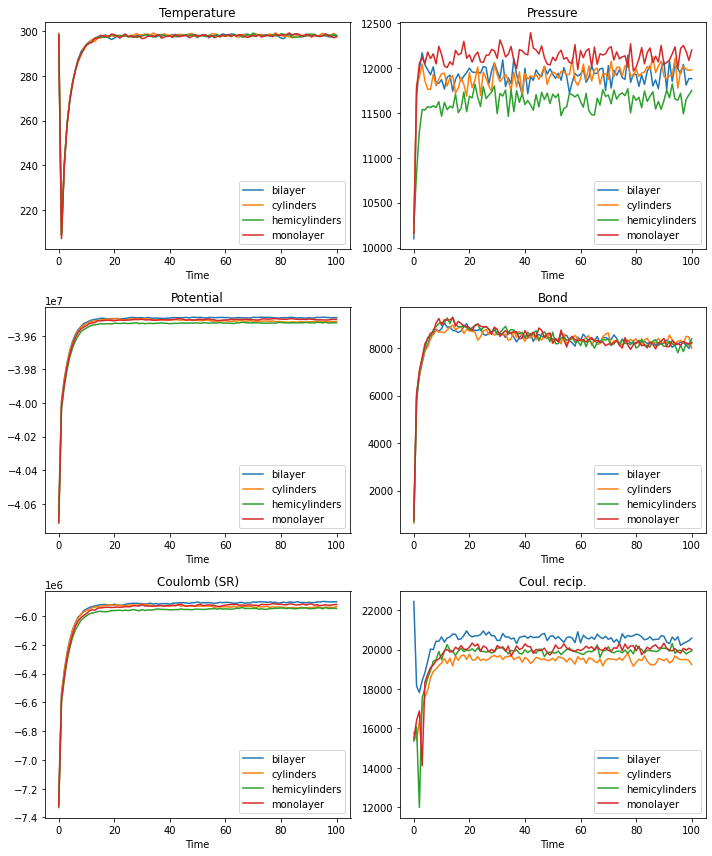

In [130]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby([parameter_keys[0]]):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [131]:
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsNVTEquilibration'},
    'metadata.type': 'mp4_file',
}

In [132]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

4

In [135]:
#parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

....

In [136]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

('monolayer',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03\xe8\xd9mdat\x0…

('hemicylinders',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04\xe3\x1fmdat\x0…

('cylinders',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\t\xb1\xb0mdat\x00\…

('bilayer',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08J\xeemdat\x00\x…

## NPT equilibration analysis

### Overview on objects in step

In [311]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsNPTEquilibration:push_filepad'}
}

In [312]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

80

In [313]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [314]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-09-09 23:24:22.996721,2020-09-09 23:24:23.582484,4
1,surfactant_tail_rmsd,NaN,2020-09-09 23:24:22.996717,2020-09-09 23:24:23.582479,4
2,surfactant_head_rmsd,NaN,2020-09-09 23:24:22.996712,2020-09-09 23:24:23.582474,4
3,substrate_rmsd,NaN,2020-09-09 23:24:22.996706,2020-09-09 23:24:23.582468,4
4,counterion_rmsd,NaN,2020-09-09 23:24:22.996701,2020-09-09 23:24:23.582463,4
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.996696,2020-09-09 23:24:23.582458,4
6,surfactant_head_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.996691,2020-09-09 23:24:23.582453,4
7,surfactant_head_surfactant_head_rdf,NaN,2020-09-09 23:24:22.996686,2020-09-09 23:24:23.582448,4
8,substrate_surfactant_tail_rdf,NaN,2020-09-09 23:24:22.996681,2020-09-09 23:24:23.582443,4
9,substrate_surfactant_head_rdf,NaN,2020-09-09 23:24:22.996676,2020-09-09 23:24:23.582438,4


### Global observables

In [156]:
query = { 
    "metadata.project": project_id,
    'metadata.step': {'$regex': 'GromacsNPTEquilibration'},
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

4

In [157]:
metadata = fp.filepad.find_one(query)

In [158]:
metadata

{'_id': ObjectId('5f599c4471af2580b88a4217'),
 'identifier': '/p/scratch/chfr13/hoermann/fireworks/launchpad/launcher_2020-09-10-03-23-45-053257/default.edr',
 'original_file_name': 'default.edr',
 'original_file_path': '/p/scratch/chfr13/hoermann/fireworks/launchpad/launcher_2020-09-10-03-23-45-053257/default.edr',
 'metadata': {'project': '2020-09-10-sds-on-au-111-substrate-passivation-trial',
  'datetime': '2020-09-09 23:24:23.195935',
  'step': 'SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:push_filepad',
  'source_project_id': '2020-08-24-au-111-fcc-substrate-creation-trial',
  'source_step': 'LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisualize:push_filepad',
  'metadata_fp_source_key': 'metadata->system->substrate',
  'metadata_fw_dest_key': 'metadata->system->substrate',
  'metadata_fw_source_key': 'metadata->system->substrate',
  'description': 'Trial runs for SDS on Au(111) substrate passivation',
  'owners

In [160]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [161]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [162]:
[ c for c in cursor]

[{'_id': {'shape': 'bilayer'},
  'degeneracy': 1,
  'latest': '5f599c4471af2580b88a4215'},
 {'_id': {'shape': 'hemicylinders'},
  'degeneracy': 1,
  'latest': '5f59a06486292b88958a40c6'},
 {'_id': {'shape': 'cylinders'},
  'degeneracy': 1,
  'latest': '5f599d74e4b09a73898a0bae'},
 {'_id': {'shape': 'monolayer'},
  'degeneracy': 1,
  'latest': '5f599d5e86292b88958a2340'}]

In [163]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

....


In [164]:
res_df.columns

Index(['shape', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Box-X',
       'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV', 'Enthalpy', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfactant-rest', '

In [165]:
res_df_mi

Time         Bond           U-B   Proper Dih.        LJ-14  \
shape     step                                                                 
monolayer 0.0      0.0  8382.078125  72183.328125  17587.406250  4508.233398   
          1.0      1.0  8149.355469  72356.750000  17063.722656  4365.340820   
          2.0      2.0  7997.191895  71931.304688  17114.197266  4283.055176   
          3.0      3.0  8382.287109  72080.562500  17096.052734  4357.097656   
          4.0      4.0  8224.378906  71519.867188  17008.138672  4447.820312   
...                ...          ...           ...           ...          ...   
bilayer   96.0    96.0  7303.081055  66338.437500  15825.512695  4111.479004   
          97.0    97.0  7069.416504  66706.125000  16069.733398  4185.811035   
          98.0    98.0  6930.011230  66464.804688  15941.565430  4038.724609   
          99.0    99.0  7137.024414  66275.226562  15951.377930  4011.985596   
          100.0  100.0  7314.002930  66130.148438  15882.808594  4175.300293   

                    Coulomb-14     LJ (SR)  Coulomb (SR)  ...  \
shape     step                                            ...   
monolayer 0.0    114375.437500 -33832784.0    -5918648.5  ...   
          1.0    114329.851562 -34997872.0    -5923011.5  ...   
          2.0    114267.085938 -35183312.0    -5931801.5  ...   
          3.0    114090.835938 -35303808.0    -5926936.0  ...   
          4.0    114359.609375 -35368796.0    -5931212.0  ...   
...                        ...         ...           ...  ...   
bilayer   96.0   115312.351562 -35487068.0    -5923972.5  ...   
          97.0   115304.687500 -35486576.0    -5929849.5  ...   
          98.0   115275.867188 -35485208.0    -5931968.5  ...   
          99.0   115285.742188 -35487704.0    -5927449.5  ...   
          100.0  115447.640625 -35487256.0    -5927537.5  ...   

                 Coul-SR:rest-rest  LJ-SR:rest-rest  Coul-14:rest-rest  \
shape     step                                                           
monolayer 0.0           -5459993.0      552137.5625                0.0   
          1.0           -5461603.5      551796.1250                0.0   
          2.0           -5471519.0      557857.8750                0.0   
          3.0           -5466070.5      551054.6875                0.0   
          4.0           -5471418.0      554735.4375                0.0   
...                            ...              ...                ...   
bilayer   96.0          -5417561.5      565434.0000                0.0   
          97.0          -5423601.0      566144.4375                0.0   
          98.0          -5426061.0      567365.4375                0.0   
          99.0          -5419939.5      564097.9375                0.0   
          100.0         -5420236.0      564825.8750                0.0   

                 LJ-14:rest-rest  T-non-Substrate  T-Substrate  \
shape     step                                                   
monolayer 0.0                0.0       298.790253     0.904312   
          1.0                0.0       297.111389   202.802505   
          2.0                0.0       296.245148   125.197792   
          3.0                0.0       296.467773    77.325508   
          4.0                0.0       295.350525    48.722988   
...                          ...              ...          ...   
bilayer   96.0               0.0       295.093658     3.882748   
          97.0               0.0       295.331055     3.848650   
          98.0               0.0       295.203033     3.872101   
          99.0               0.0       295.106354     3.855640   
          100.0              0.0       295.574677     3.866356   

                 Lamb-non-Substrate  Lamb-Substrate  
shape     step                                       
monolayer 0.0                   1.0             1.0  
          1.0                   1.0             1.0  
          2.0                   1.0             1.0  
          3.0                   1.0    

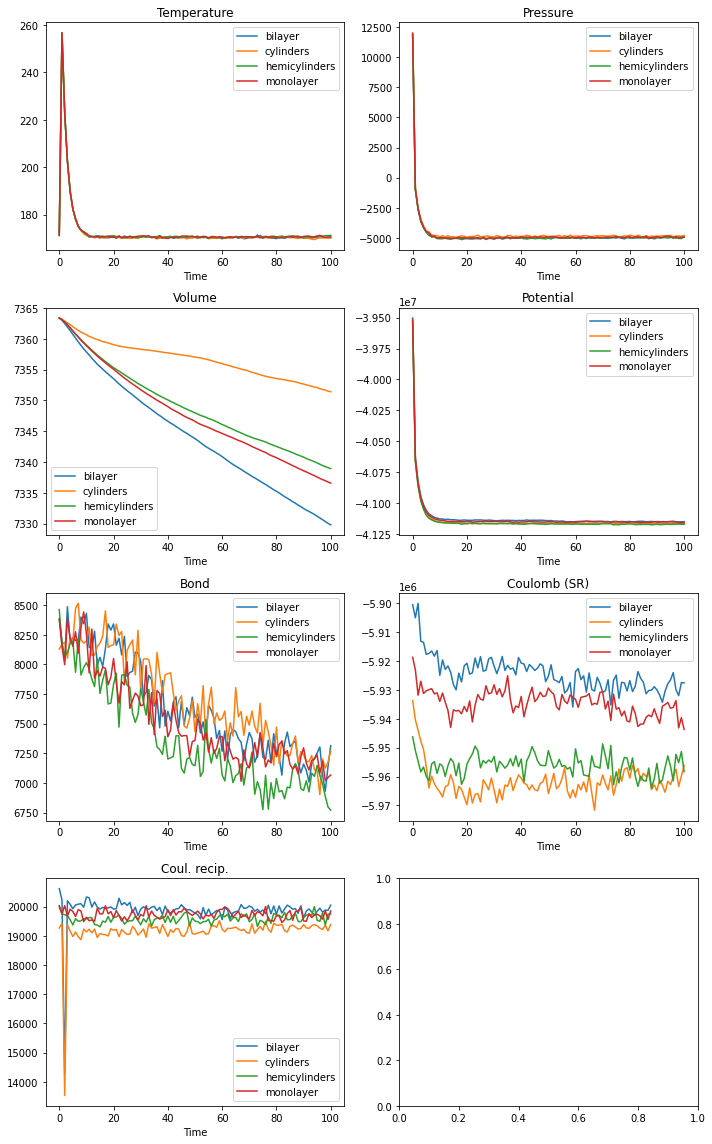

In [167]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby([parameter_keys[0]]):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [168]:
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsNPTEquilibration'},
    'metadata.type': 'mp4_file',
}

In [169]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

4

In [173]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [174]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

....

In [175]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

('monolayer',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04\x12\xacmdat\x0…

('hemicylinders',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04\xf7\xdcmdat\x0…

('cylinders',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\n0\xc8mdat\x00\x00…

('bilayer',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\tC\xf2mdat\x00\x00…


### Pre-evaluated RDF

#### Overview

In [176]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": {'$regex': "GromacsNPTEquilibration"},
}

fp.filepad.count_documents(query)

36

In [177]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [178]:
res_df

,type,earliest,latest,object_count
0,surfactant_tail_surfactant_tail_rdf,2020-09-09 23:24:22.996696,2020-09-09 23:24:23.582458,4
1,surfactant_head_surfactant_tail_rdf,2020-09-09 23:24:22.996691,2020-09-09 23:24:23.582453,4
2,surfactant_head_surfactant_head_rdf,2020-09-09 23:24:22.996686,2020-09-09 23:24:23.582448,4
3,substrate_surfactant_tail_rdf,2020-09-09 23:24:22.996681,2020-09-09 23:24:23.582443,4
4,substrate_surfactant_head_rdf,2020-09-09 23:24:22.996676,2020-09-09 23:24:23.582438,4
5,counterion_surfactant_tail_rdf,2020-09-09 23:24:22.996671,2020-09-09 23:24:23.582433,4
6,counterion_surfactant_head_rdf,2020-09-09 23:24:22.996665,2020-09-09 23:24:23.582427,4
7,counterion_substrate_rdf,2020-09-09 23:24:22.996660,2020-09-09 23:24:23.582422,4
8,counterion_counterion_rdf,2020-09-09 23:24:22.996655,2020-09-09 23:24:23.582417,4


#### Substrate - surfactant head RDF

In [181]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": {'$regex': "GromacsNPTEquilibration"},
}

fp.filepad.count_documents(query)

4

In [182]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [187]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


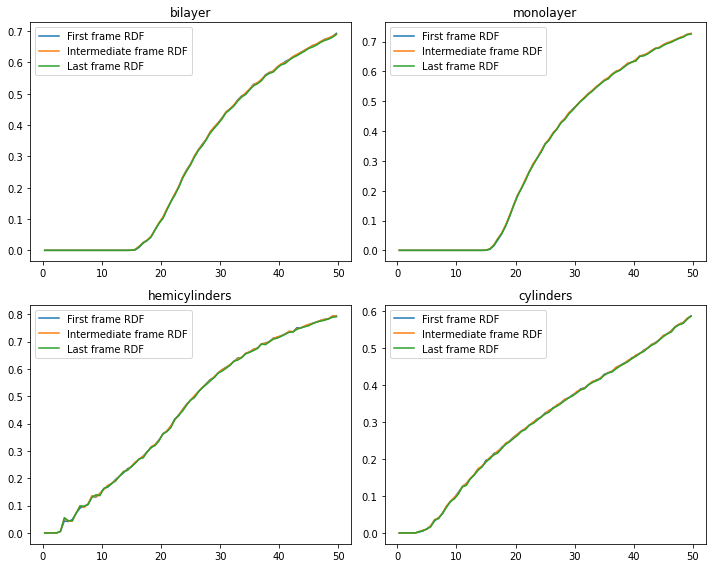

In [188]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Substrate - surfactant tail RDF

In [189]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsNPTEquilibration"},
}

fp.filepad.count_documents(query)

4

In [190]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


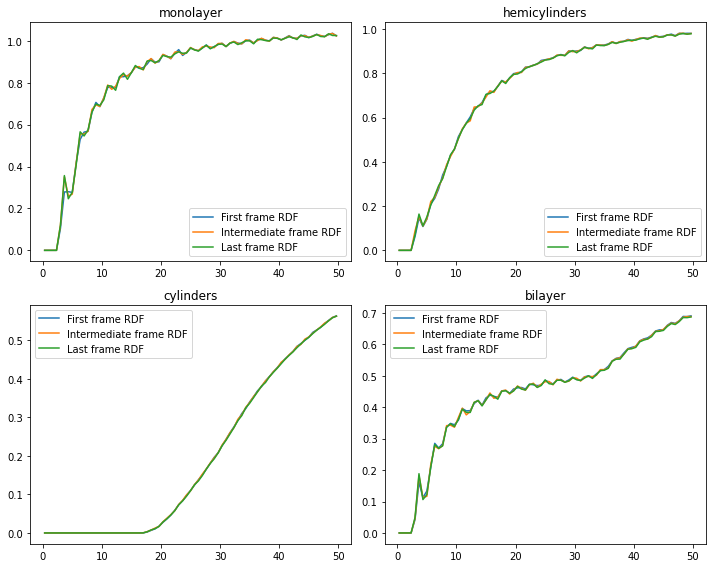

In [191]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant tail RDF

In [194]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsNPTEquilibration"},
}

fp.filepad.count_documents(query)

4

In [196]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
    }
}

aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


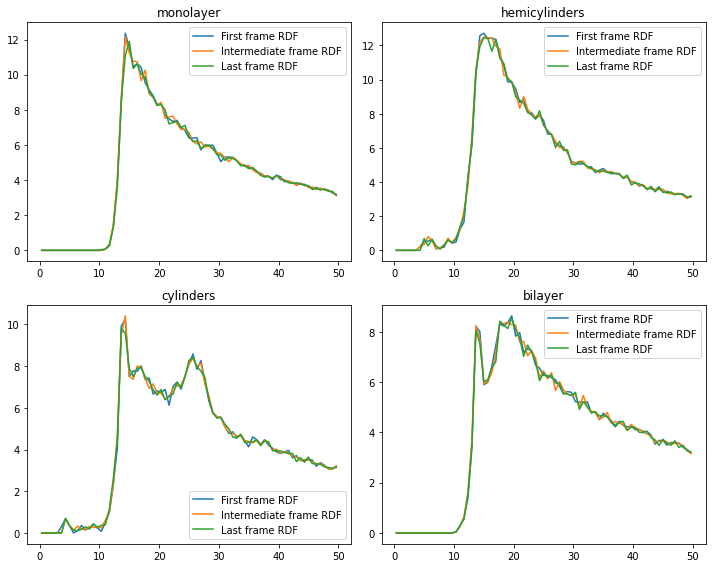

In [197]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

## Relaxation analysis

### Overview on objects in step

In [201]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsRelaxation'}
}

In [202]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

89

In [203]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [204]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-09-09 23:24:23.239028,2020-09-09 23:24:23.635704,3
1,surfactant_tail_rmsd,NaN,2020-09-09 23:24:23.239024,2020-09-09 23:24:23.635698,3
2,surfactant_head_rmsd,NaN,2020-09-09 23:24:23.239019,2020-09-09 23:24:23.635693,3
3,substrate_rmsd,NaN,2020-09-09 23:24:23.239014,2020-09-09 23:24:23.635688,3
4,counterion_rmsd,NaN,2020-09-09 23:24:23.239009,2020-09-09 23:24:23.635683,3
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-09-09 23:24:23.239004,2020-09-09 23:24:23.635678,3
6,surfactant_head_surfactant_tail_rdf,NaN,2020-09-09 23:24:23.238999,2020-09-09 23:24:23.635672,3
7,surfactant_head_surfactant_head_rdf,NaN,2020-09-09 23:24:23.045566,2020-09-09 23:24:23.635667,4
8,substrate_surfactant_tail_rdf,NaN,2020-09-09 23:24:23.045562,2020-09-09 23:24:23.635662,4
9,substrate_surfactant_head_rdf,NaN,2020-09-09 23:24:23.045557,2020-09-09 23:24:23.635657,4


### Global observables

In [205]:
query = { 
    "metadata.project": project_id,
    'metadata.step': {'$regex': 'GromacsRelaxation'},
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

5

In [208]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [209]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [210]:
[ c for c in cursor]

[{'_id': {'shape': 'bilayer'},
  'degeneracy': 1,
  'latest': '5f5a90dc86292b88958a5e8c'},
 {'_id': {'shape': 'cylinders'},
  'degeneracy': 1,
  'latest': '5f5a8c6dcd1d380ee68a1040'},
 {'_id': {'shape': 'hemicylinders'},
  'degeneracy': 1,
  'latest': '5f5aaf0be4b09a73898a5c1f'},
 {'_id': {'shape': 'monolayer'},
  'degeneracy': 2,
  'latest': '5f5a9b2871af2580b88a8744'}]

In [211]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

....


In [212]:
res_df.columns

Index(['shape', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Box-X',
       'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV', 'Enthalpy', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfactant-rest', '

In [213]:
res_df_mi

Time         Bond           U-B   Proper Dih.  \
shape     step                                                      
monolayer 0.0        0.0  7223.410645  65654.695312  16249.834961   
          1.0        1.0  7198.032715  65659.914062  16424.638672   
          2.0        2.0  7222.201660  65903.757812  16547.056641   
          3.0        3.0  7047.880371  66441.539062  16570.699219   
          4.0        4.0  7046.148926  66140.953125  16389.451172   
...                  ...          ...           ...           ...   
bilayer   2996.0  2996.0  7303.650879  67416.187500  16579.191406   
          2997.0  2997.0  7345.809082  67305.734375  16772.031250   
          2998.0  2998.0  7094.135742  67380.578125  16454.548828   
          2999.0  2999.0  7140.964844  68143.203125  16749.792969   
          3000.0  3000.0  7205.909180  67207.687500  16903.978516   

                        LJ-14     Coulomb-14     LJ (SR)  Coulomb (SR)  ...  \
shape     step                                                          ...   
monolayer 0.0     4160.901367  114225.070312 -35478464.0    -5943828.0  ...   
          1.0     4298.438477  113938.078125 -35485352.0    -5940515.0  ...   
          2.0     4372.271973  113741.601562 -35486736.0    -5937446.5  ...   
          3.0     4350.555176  113570.437500 -35484108.0    -5938026.0  ...   
          4.0     4304.707031  113616.437500 -35487620.0    -5937630.0  ...   
...                       ...            ...         ...           ...  ...   
bilayer   2996.0  4399.190430  109668.195312 -35478332.0    -5989498.0  ...   
          2997.0  4551.566406  109730.054688 -35476248.0    -5993491.5  ...   
          2998.0  4294.160156  109435.343750 -35473924.0    -5993601.0  ...   
          2999.0  4263.392090  109097.093750 -35474740.0    -5995494.5  ...   
          3000.0  4415.067383  109450.804688 -35479364.0    -5988231.5  ...   

                  Coul-SR:rest-rest  LJ-SR:rest-rest  Coul-14:rest-rest  \
shape     step                                                            
monolayer 0.0            -5475272.5      564474.7500                0.0   
          1.0            -5470907.5      564325.4375                0.0   
          2.0            -5468200.0      562426.5000                0.0   
          3.0            -5468861.5      563748.1875                0.0   
          4.0            -5468942.0      561881.3125                0.0   
...                             ...              ...                ...   
bilayer   2996.0         -5460384.5      576301.8125                0.0   
          2997.0         -5465812.0      579761.6875                0.0   
          2998.0         -5466669.5      581253.1250                0.0   
          2999.0         -5467429.0      580473.0625                0.0   
          3000.0         -5460755.5      575963.3125                0.0   

                  LJ-14:rest-rest  T-non-Substrate  T-Substrate  \
shape     step                                                    
monolayer 0.0                 0.0       296.641144     3.683269   
          1.0                 0.0       294.621796     4.266482   
          2.0                 0.0       294.798981     4.200392   
          3.0                 0.0       294.128418     4.088758   
          4.0                 0.0       294.599854     4.005237   
...                           ...              ...          ...   
bilayer   2996.0              0.0       294.940063     4.068172   
          2997.0              0.0       294.408569     4.047864   
          2998.0              0.0       294.667877     4.077587   
          2999.0              0.0       295.378540     4.094872   
          3000.0              0.0       294.537689     4.079585   

                  Lamb-non-Substrate  Lamb-Substrate  
shape     step                                        
monolayer 0.0                    1.0             1.0  
          1.0                    1.0             1.0  
          2.0             

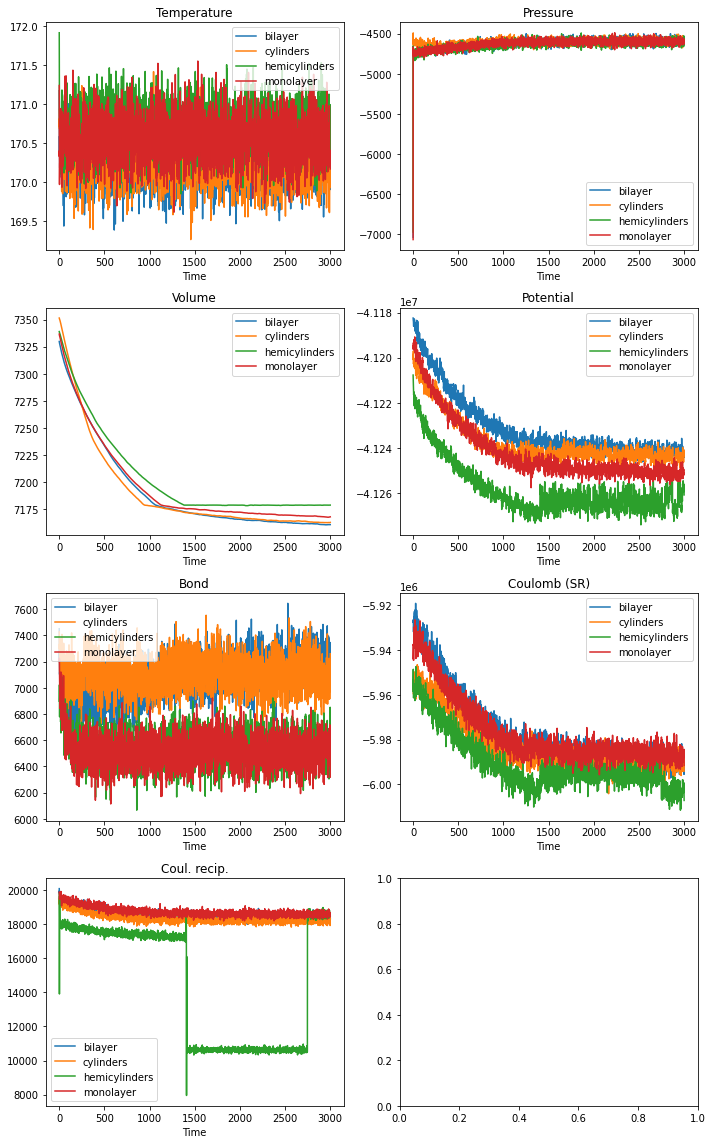

In [214]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby([parameter_keys[0]]):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [215]:
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsRelaxation'},
    'metadata.type': 'mp4_file',
}

In [216]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

3

In [217]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [218]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

...

In [219]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

('hemicylinders',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\xca\t\x18mdat\x00\…

('cylinders',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\x03\x8d\x7fmdat\x0…

('bilayer',)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\x0b\xe7\x99mdat\x0…


### Pre-evaluated RDF

#### Overview

In [223]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

34

In [224]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [225]:
res_df

,type,earliest,latest,object_count
0,surfactant_tail_surfactant_tail_rdf,2020-09-09 23:24:23.239004,2020-09-09 23:24:23.635678,3
1,surfactant_head_surfactant_tail_rdf,2020-09-09 23:24:23.238999,2020-09-09 23:24:23.635672,3
2,surfactant_head_surfactant_head_rdf,2020-09-09 23:24:23.045566,2020-09-09 23:24:23.635667,4
3,substrate_surfactant_tail_rdf,2020-09-09 23:24:23.045562,2020-09-09 23:24:23.635662,4
4,substrate_surfactant_head_rdf,2020-09-09 23:24:23.045557,2020-09-09 23:24:23.635657,4
5,counterion_surfactant_tail_rdf,2020-09-09 23:24:23.045551,2020-09-09 23:24:23.635652,4
6,counterion_surfactant_head_rdf,2020-09-09 23:24:23.045545,2020-09-09 23:24:23.635647,4
7,counterion_substrate_rdf,2020-09-09 23:24:23.045541,2020-09-09 23:24:23.635642,4
8,counterion_counterion_rdf,2020-09-09 23:24:23.045536,2020-09-09 23:24:23.635637,4


#### Substrate - surfactant head RDF

In [226]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

4

In [227]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [228]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


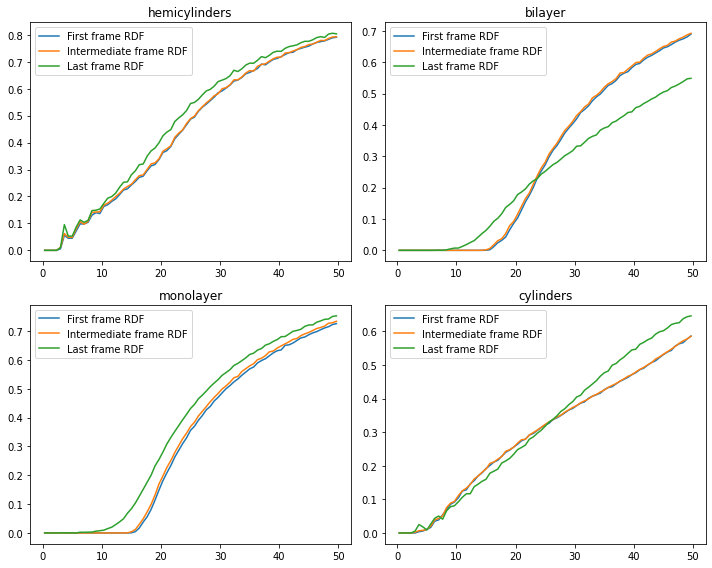

In [229]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Substrate - surfactant tail RDF

In [230]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

4

In [231]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


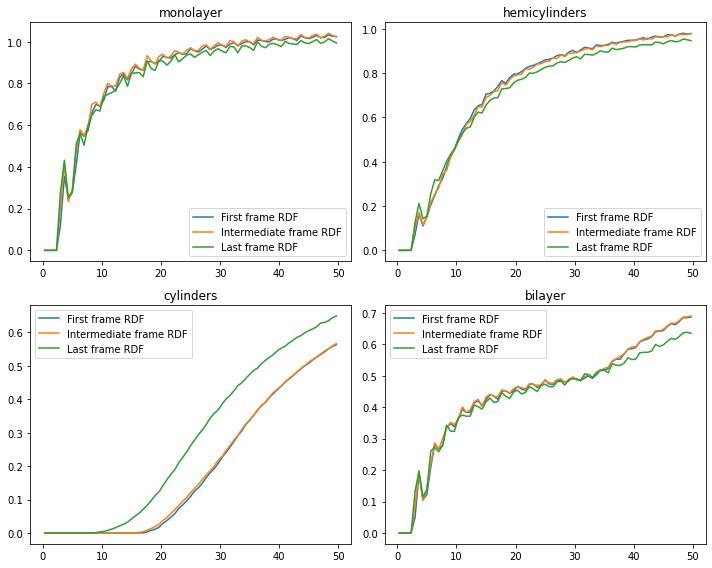

In [232]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant tail RDF

In [233]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

3

In [234]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
    }
}

aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

...


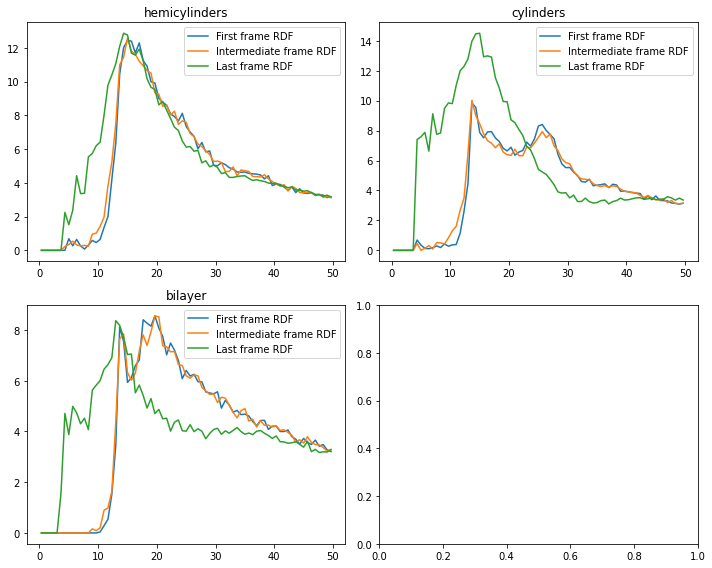

In [235]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant head RDF

In [265]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_head_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

4

In [266]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [267]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


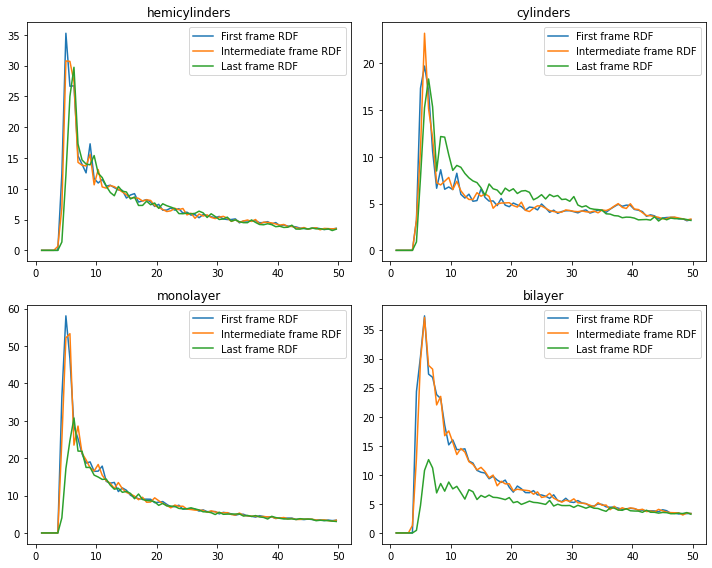

In [268]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][1:],data['rdf'][0][1:], label='First frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][len(data)//2][1:],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][-1][1:],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

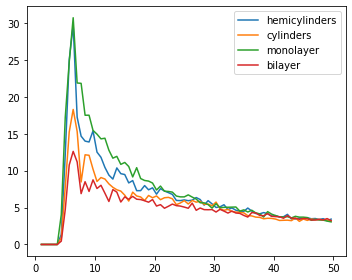

In [269]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'][1:],data['rdf'][-1][1:],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant tail - surfactant tail RDF

In [270]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_tail_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

3

In [271]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [272]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

...


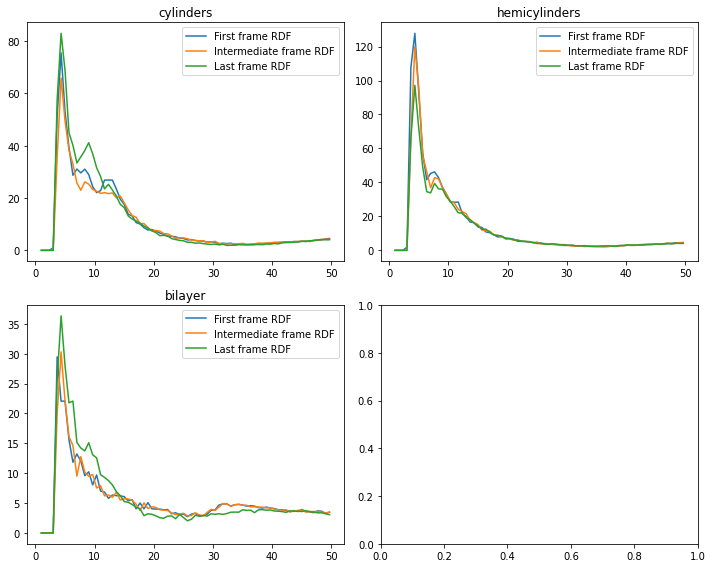

In [273]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][1:],data['rdf'][0][1:], label='First frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][len(data)//2][1:],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][-1][1:],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

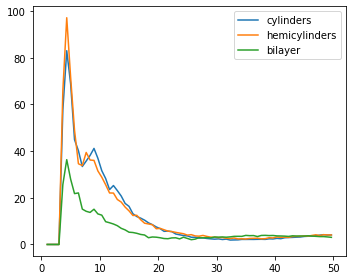

In [274]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'][1:],data['rdf'][-1][1:],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Counterion - surfactant head RDF

In [236]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_surfactant_head_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

4

In [237]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [238]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


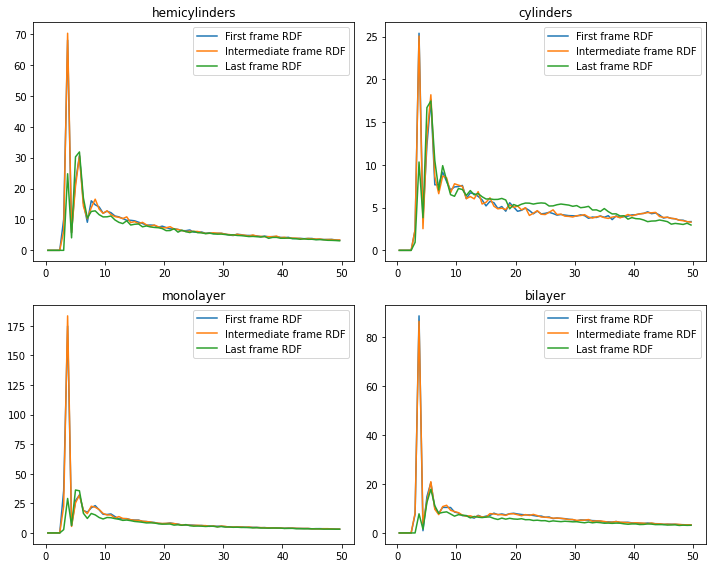

In [241]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

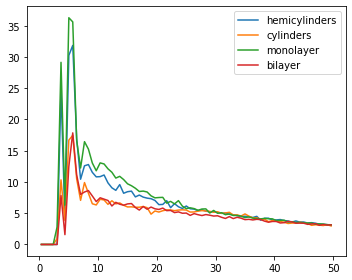

In [245]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'],data['rdf'][-1],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Counterion - surfactant tail RDF

In [247]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

4

In [248]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [249]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


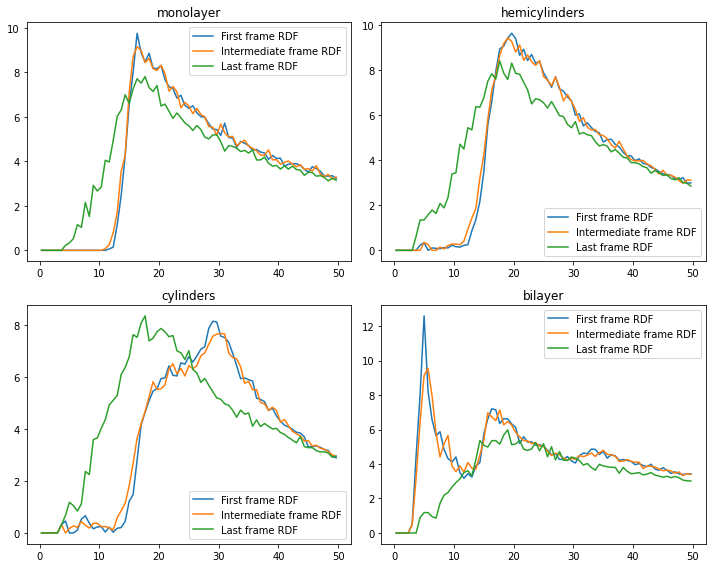

In [250]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

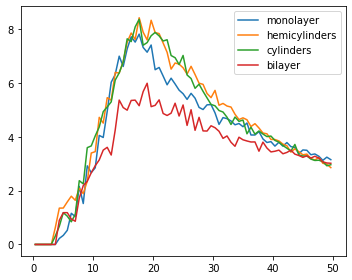

In [251]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'],data['rdf'][-1],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Counterion - substrate RDF

In [252]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_substrate_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

4

In [253]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [254]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


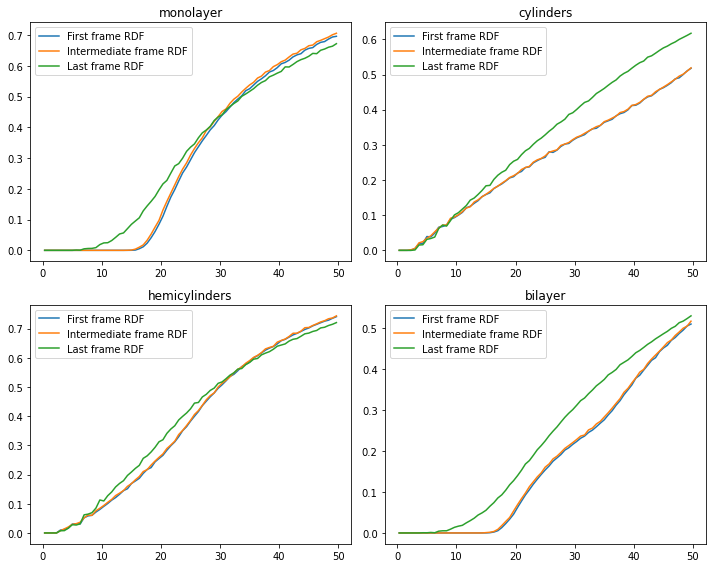

In [255]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

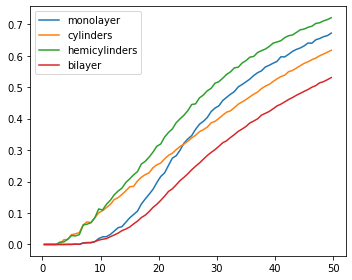

In [256]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'],data['rdf'][-1],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Counterion - counterion RDF

In [257]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_counterion_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

4

In [258]:
parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_keys = list(parameter_dict.keys())

In [259]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_key = c["_id"][parameter_keys[0]]
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_key] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

....


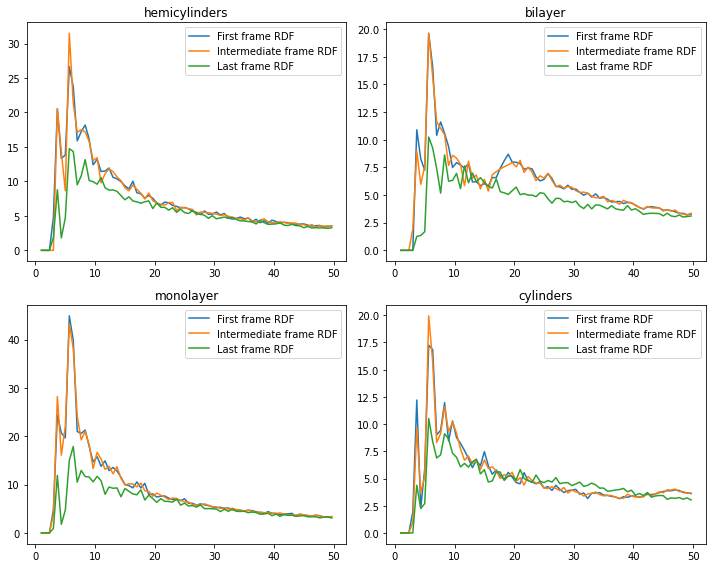

In [263]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][1:],data['rdf'][0][1:], label='First frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][len(data)//2][1:],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][-1][1:],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

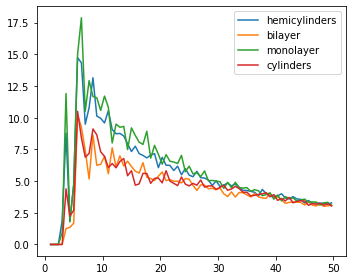

In [264]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'][1:],data['rdf'][-1][1:],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()